In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import rcParams
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import utilities as ut

# Definimos el area de la cabecilla del imán en mm^2
HEAD_AREA_MM2 = 1000*(924)*1e-6  #largo*(diametro) de la cabecilla [µm^2 -> mm^2]
FRAME_PER_SECOND = 60

COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (28, 18)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 30
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# Adquisición y procesamiento de datos de la cola

In [2]:
#Obtenemos el tracking de la cola para todo tiempo
vs = cv.VideoCapture(f'example_media/ECO20-45mm-2,00Vpp-8Hz.mp4')
lim = [310, 950, 205, 505] #[xleft, xright, ytop, ydown]
sk, tail_xy,_ = ut.track_tail(vs, lim, SHOW=True)
#sk es el frame entero y tail_xy es los índices de la cola en cada frame
for i in np.arange(tail_xy.shape[0]):
    tail = tail_xy[i]
    sk[i][tail] = 0
    tail_x = tail[1] - np.min(tail[1]) #We remove the smallest index to make it start on 0
    tail_y = tail[0] - np.min(tail[0])
    sk[i][tail_y + 15,tail_x] = 1 #We arbitrarily add a number so our data looks nicer
    tail_xy[i] = (tail_x, tail_y + 15)

Termina en frame 200


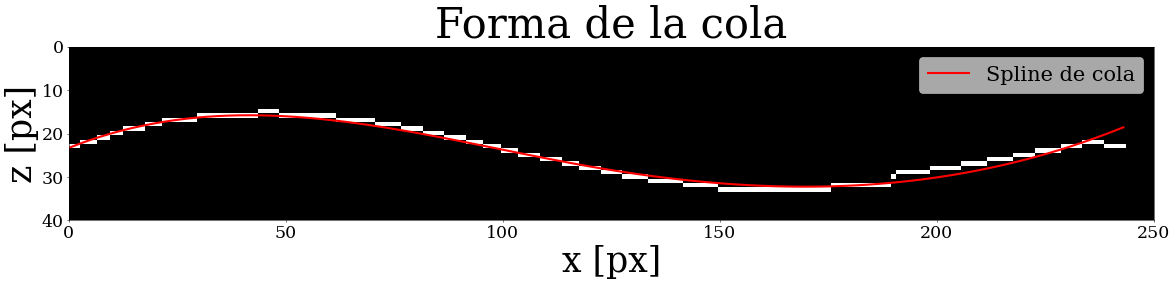

In [3]:
xs, ys = ut.spline_skeleton(tail_x=tail_xy[0][0], tail_y=tail_xy[0][1])

plt.imshow(sk[0], cmap='gray')
plt.plot(xs, ys, 'r', lw=3, label='Spline de cola')

plt.title('Forma de la cola')
plt.xlabel('x [px]')
plt.ylabel('z [px]')

plt.xlim(0,250)
plt.ylim(40,0)
plt.legend()

(50.0, 0.0)

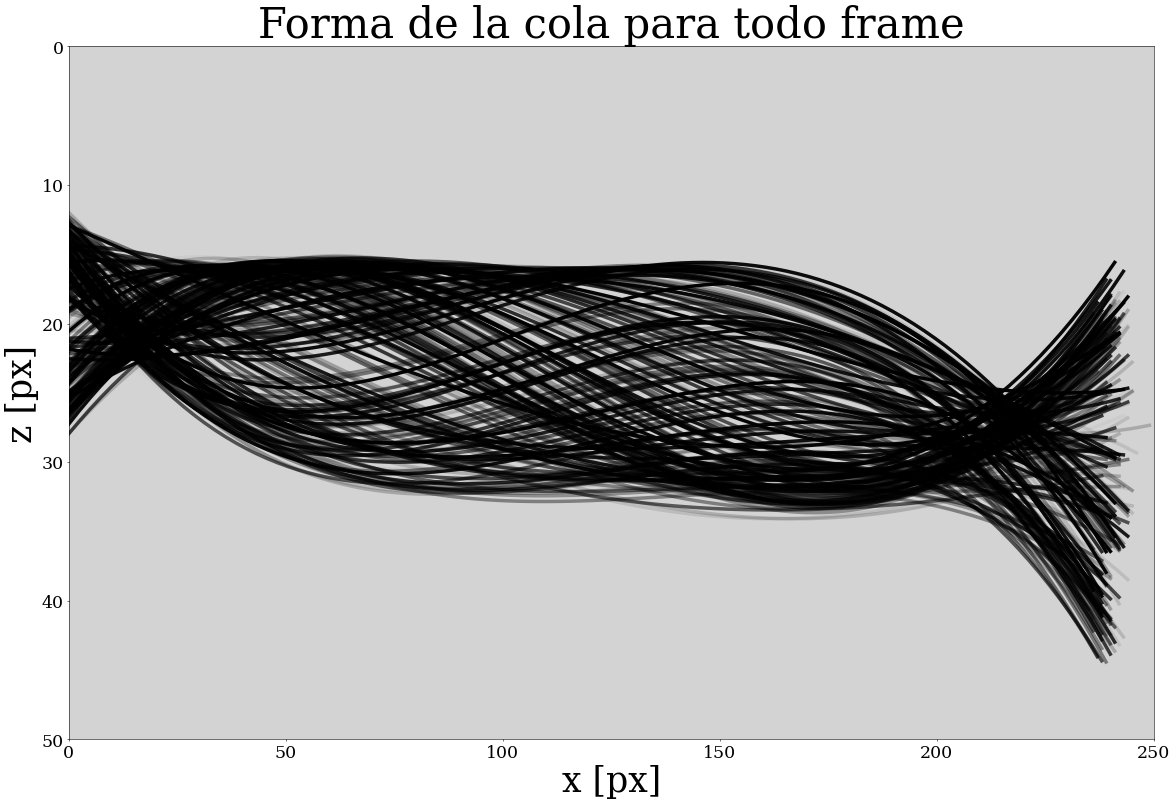

In [4]:
for i in np.arange(tail_xy.size):
    xs, ys = ut.spline_skeleton(tail_x=tail_xy[i][0], tail_y=tail_xy[i][1])
    plt.plot(xs,ys, color='k', lw=5, alpha=(i/tail_xy.size))

plt.title('Forma de la cola para todo frame')
plt.xlabel('x [px]')
plt.ylabel('z [px]')

plt.xlim(0,250)
plt.ylim(50,0)

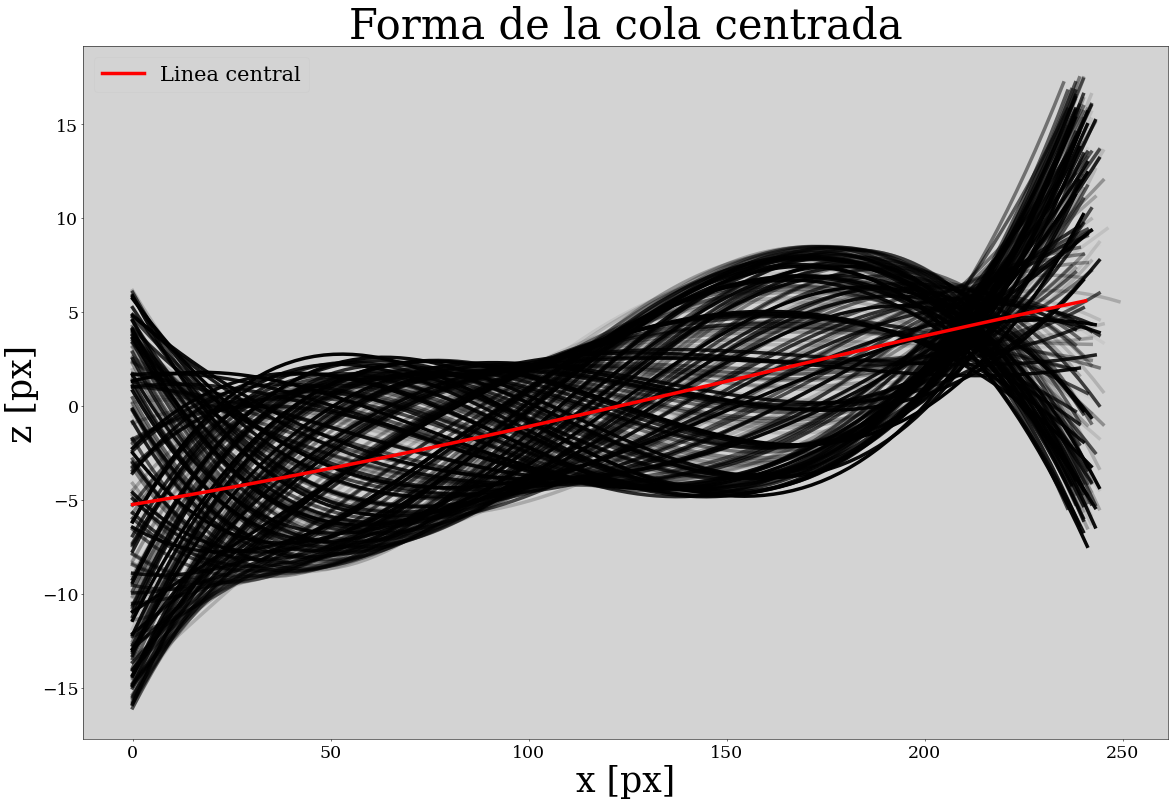

In [5]:
centered_tails = np.zeros((tail_xy.shape[0],100))
x_tails = np.zeros((tail_xy.shape[0],100))

#We center the tail around 0
for i in np.arange(tail_xy.shape[0]):
    xs, ys = ut.spline_skeleton(tail_x=tail_xy[i][0], tail_y=tail_xy[i][1])
    avg_y = np.mean(ys)
    centered_tails[i] = ys - avg_y
    x_tails[i] = xs
    plt.plot(xs,centered_tails[i], color='k', lw=5, alpha=i/tail_xy.shape[0])
    
center_line = np.mean(centered_tails, axis=0)
avg_x_tails = np.mean(x_tails, axis=0)

center_point = [np.mean(avg_x_tails), np.mean(center_line)]

plt.title('Forma de la cola centrada')
plt.plot(avg_x_tails, center_line, 'r', lw=5, label='Linea central')
plt.xlabel('x [px]')
plt.ylabel('z [px]')
plt.legend()

Text(0, 0.5, 'z [px]')

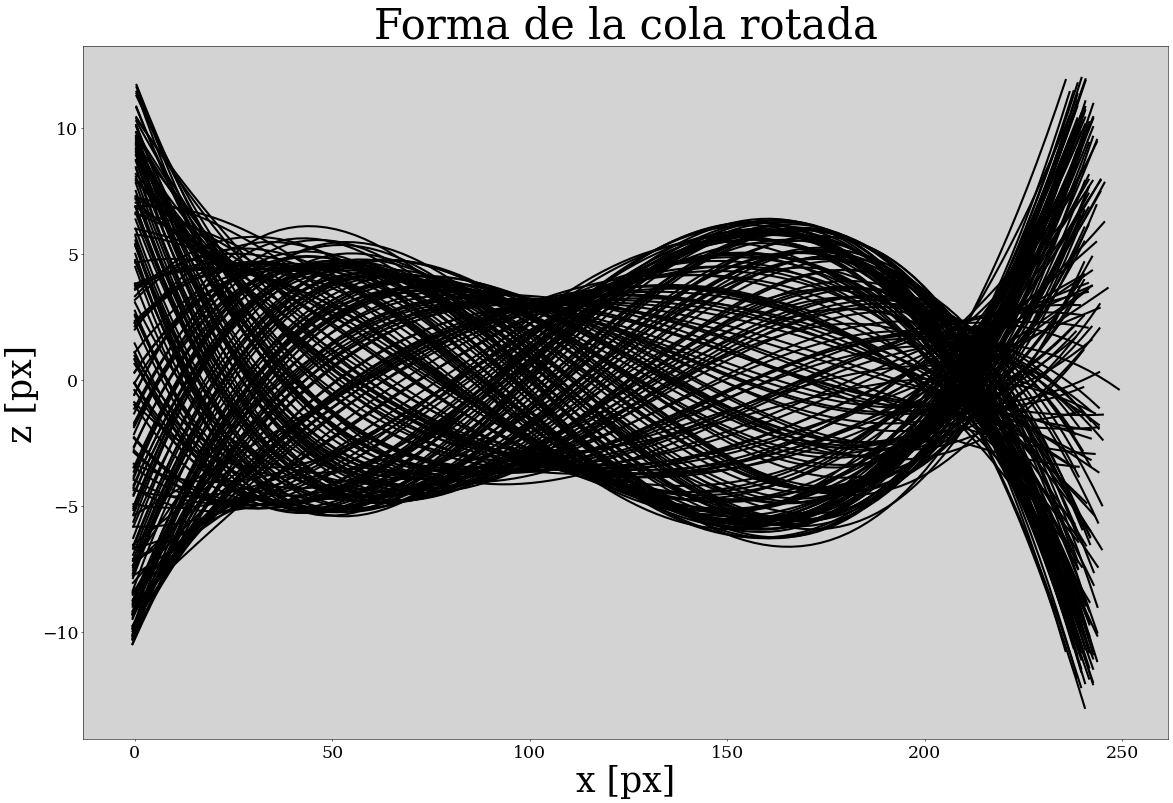

In [6]:
#Fitteamos la linea central de la cola con una función lineal
f_lineal = lambda x, a, b: a*x + b
params, cov = curve_fit(f_lineal, avg_x_tails, center_line)

#Rotamos la cola respecto del punto central con el ángulo de la recta ajustada
angle = np.degrees(np.arctan(params[0]))
rotated_tails = np.array([ut.rotate_curve(x_tail, center_tail, angle, center_point) for (x_tail,center_tail) in zip(x_tails,centered_tails)])

[plt.plot(tail[0],tail[1], color='k', lw=3) for tail in rotated_tails]
plt.title('Forma de la cola rotada')
plt.xlabel('x [px]')
plt.ylabel('z [px]')

## Amplitud de la cabeza y la punta del nadador

In [7]:
#Obtenemos la calibración del video que vamos a usar
video_name = 'ECO20-45mm-2,00Vpp-8Hz.mp4'
vs = cv.VideoCapture('example_media/{0}'.format(video_name))
limites = [319, 950, 250, 505]

#La función de calibración devuelve el resultado en px/mm
calibracion, delta_calibracion = ut.calibrate_with_head(vs, limites, HEAD_AREA_MM2)

print('Calibración promedio es: {0} +/- {1}'.format(np.mean(calibracion), np.mean(delta_calibracion)))

px_per_mm = np.mean(calibracion)
rotated_tails/=px_per_mm

Calibración promedio es: 7.479115910948772 +/- 0.008596573337805995


La amplitud promedio de la punta es 1.4622898093807024 +- 0.020947384612946658 mm
La amplitud promedio de la cabeza es 1.298987616922388 +- 0.023136813340910667 mm


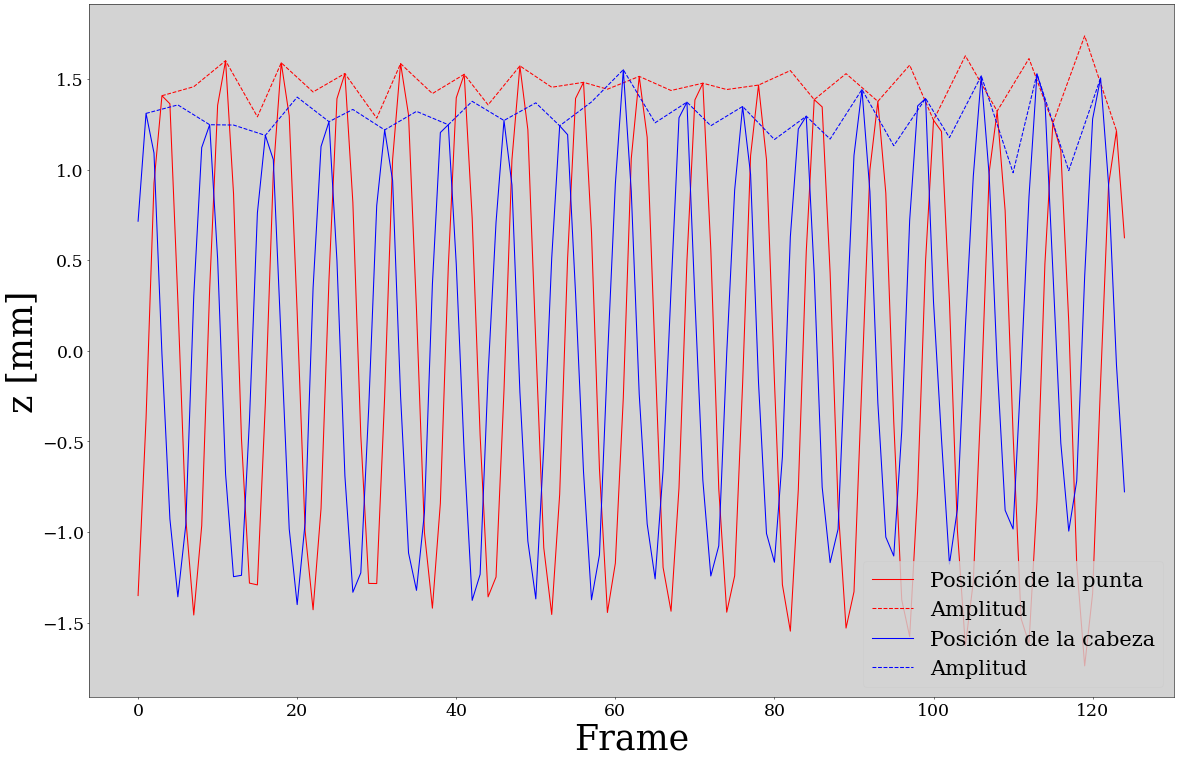

In [8]:
tail_position = []
head_position = []

#Usamos start=75 ya que la adquisición inicial de los primeros puntos no es buena
for i in np.arange(start=75,stop=len(rotated_tails)):
    # Sacado de las formas rotadas
    x,y = rotated_tails[i]
    head_position.append(y[0])
    tail_position.append(y[-1])

tail_position = np.array(tail_position)
head_position = np.array(head_position)

tail_peaks, _ = find_peaks(np.abs(tail_position))
head_peaks, _ = find_peaks(np.abs(head_position))

amplitud_tail = np.array(np.abs(tail_position[tail_peaks]))
amplitud_head = np.array(np.abs(head_position[head_peaks]))

fig,ax = plt.subplots()
plt.plot(tail_position, color='r', label='Posición de la punta')
plt.plot(tail_peaks, amplitud_tail, color='r',ls='--', label='Amplitud')
plt.legend()
plt.plot(head_position, color='b', label='Posición de la cabeza')
plt.plot(head_peaks, amplitud_head, color='b',ls='--', label='Amplitud')
plt.xlabel('Frame')
plt.ylabel('z [mm]')
plt.legend()


print("La amplitud promedio de la punta es {0} +- {1} mm".format(amplitud_tail.mean(),amplitud_tail.std()/np.sqrt(amplitud_tail.size)))
print("La amplitud promedio de la cabeza es {0} +- {1} mm".format(amplitud_head.mean(),amplitud_head.std()/np.sqrt(amplitud_head.size)))

### Diferencia de fase entre punta y cabeza

In [9]:
tail_peaks, _ = find_peaks(np.abs(tail_position))
head_peaks, _ = find_peaks(np.abs(head_position))

#Los índices son equivalentes al frame en el que se encuentran.
#Calculamos la diferencia de fase entre la cabeza y la cola
shift = (np.abs(tail_peaks - head_peaks)/FRAME_PER_SECOND)%(2*np.pi)

print("La diferencia de fase promedio es {0} +- {1} rad".format(shift.mean(),shift.std()/np.sqrt(shift.size)))

La diferencia de fase promedio es 0.03383838383838385 +- 0.0011258998566115411 rad


## Velocidad de fase

In [10]:
#Obtenemos la calibración del video que vamos a usar
video_name = 'ECO20-45mm-2,00Vpp-8Hz.mp4'
vs = cv.VideoCapture('example_media/{0}'.format(video_name))
limites = [319, 950, 250, 505]

#La función de calibración devuelve el resultado en px/mm
calibracion, delta_calibracion = ut.calibrate_with_head(vs, limites, HEAD_AREA_MM2)

print('Calibración promedio es: {0} +/- {1}'.format(np.mean(calibracion), np.mean(delta_calibracion)))

px_per_mm = np.mean(calibracion)
rotated_tails/=px_per_mm

Calibración promedio es: 7.479115910948772 +/- 0.008596573337805995


Text(0, 0.5, 'Amplitud')

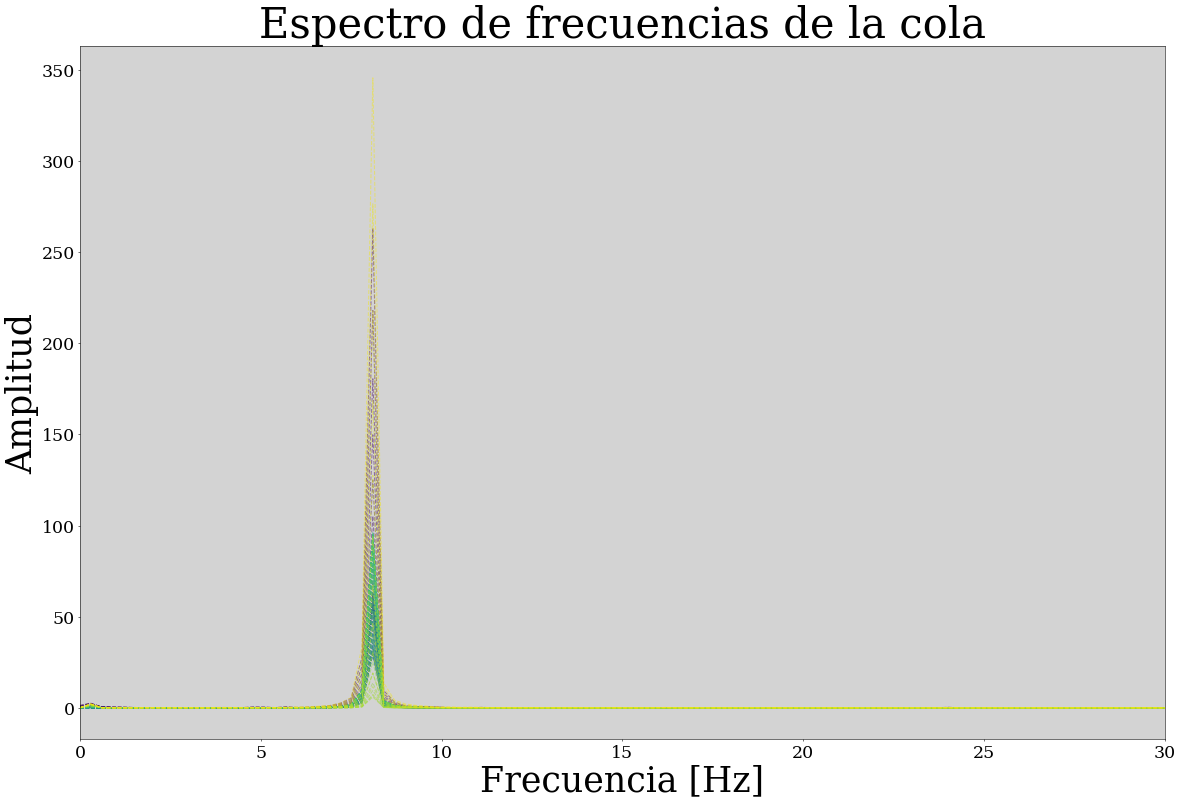

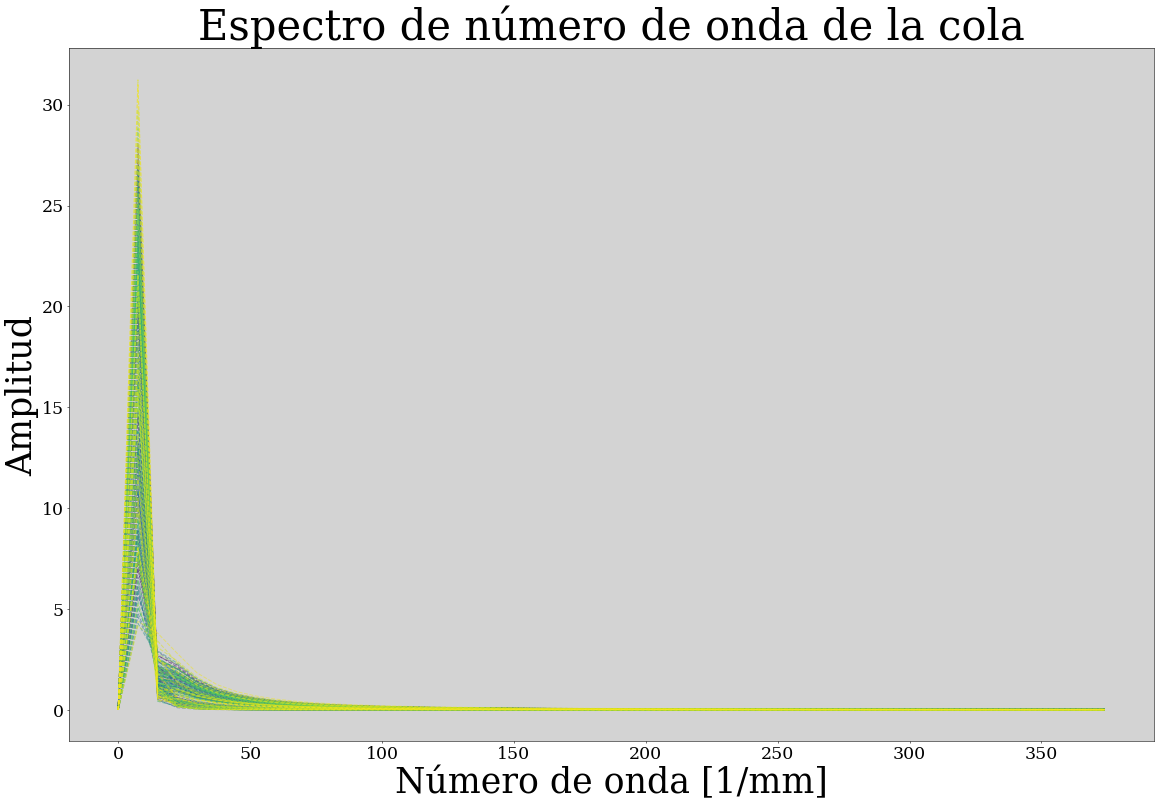

In [11]:
freq_arr = np.linspace(0,30, len(rotated_tails)//2 + 1)
space_arr = np.linspace(0,len(rotated_tails[0][0])//2, len(rotated_tails[0][0])//2 + 1)*px_per_mm

plt.figure()
[plt.plot(freq_arr, np.abs(np.fft.rfft(time_tail))**2 , color=plt.colormaps['viridis'](i/len(freq_arr)), ls='--', alpha=0.5) for i,time_tail in enumerate(rotated_tails[:,1].T)]
plt.title('Espectro de frecuencias de la cola')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud')
plt.xlim(0,30)

plt.figure()
[plt.plot(space_arr, np.abs(np.fft.rfft(space_tail))**2 , color=plt.colormaps['viridis'](i/len(rotated_tails)), ls='--', alpha=0.5) for i,space_tail in enumerate(rotated_tails[:,1])]
plt.title('Espectro de número de onda de la cola')
plt.xlabel('Número de onda [1/mm]')
plt.ylabel('Amplitud')

In [12]:
w_max = []
k_max = []

for i in np.arange(len(rotated_tails)//2):
    time_tail = rotated_tails[:,1,i]
    w_tail = np.abs(np.fft.rfft(time_tail))**2
    w_max.append(freq_arr[np.argmax(w_tail)])

for i in np.arange(len(rotated_tails[0][0])//2):
    space_tail = rotated_tails[i,1,:]
    k_tail = np.abs(np.fft.rfft(space_tail))**2
    k_max.append(space_arr[np.argmax(k_tail[1:]) + 1])
    
kmax_mean = np.mean(k_max)
wmax_mean = np.mean(w_max)

kmax_error = np.std(k_max)/np.sqrt(len(k_max))
wmax_error = np.std(w_max)/np.sqrt(len(w_max))

v = wmax_mean/kmax_mean
v_error = v*np.sqrt((wmax_error/wmax_mean)**2 + (kmax_error/kmax_mean)**2)
print('La velocidad de fase promedio es: {0} +/- {1} mm/s'.format(v, v_error))

La velocidad de fase promedio es: 1.0830157061936032 +/- 1.818861815409355e-17 mm/s
